# Tutorial 9: Recurrent GNNs

In this tutorial we will implement an approximation of the Graph Neural Network Model (without enforcing contraction map) and analyze the GatedGraph Convolution of Pytorch Geometric.

In [ ]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.0.0+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 41.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
!pip install sentence_transformers

In [ ]:
import os.path as osp
import torch
import pickle
from sentence_transformers import SentenceTransformer, util
import pandas as pd
import torch.nn as nn
import numpy as np
import networkx as nx
import torch.nn.functional as F
import torch_geometric.transforms as T
import torch_geometric
from torch_geometric.datasets import Planetoid, TUDataset
from torch_geometric.data import DataLoader
from torch_geometric.nn.inits import uniform
from torch.nn import Parameter as Param
from sklearn.model_selection import train_test_split
from torch import Tensor 
from torch_geometric.nn.models import GraphUNet
import random
torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = "cpu"
from torch_geometric.nn.conv import MessagePassing

In [ ]:
with open('compact_graph.pickle','rb') as f:
   G = pickle.load(f)
graph = G['baking a cake']
# graph = G['repairing a flat bicycle tire']
G_main = graph

In [ ]:
graph.nodes

NodeView(('buy-ingredients', 'preheat', 'choose-recipe', 'add-ingredients', 'get-utensils', 'other-return-home', 'other-read-instrauctions', 'get-ingredients', 'other-enter-kitchen', 'other-read-instructions', 'put-cake-oven', 'other-make-cake', 'prepare-ingredients', 'measure-ingredients', 'grease-cake-tin', 'pour-dough', 'wait', 'turn-off-oven', 'set-time', 'take-out-oven', 'cool-down', 'Victory', 'other-clean', 'decorate', 'check', 'other-return-oven', 'other-bake-extra-time', 'eat', 'take-out-cake-tin'))

In [ ]:
def make_graph_from_sample(paths):
   
  G = nx.DiGraph()
  for path in paths:
      for i in range(len(path)-1):
         G.add_node(path[i])
         G.add_node(path[i+1])
         G.add_edge(path[i],path[i+1])

  return G

In [ ]:
def non_overlapping_samples(lst, n, k):
  P = []
  for i in range(n):
    sampled_list = random.sample(lst, k)
    P.append(sampled_list)
  return P

In [ ]:
node_list = list(nx.topological_sort(graph))
paths = list(nx.all_simple_paths(graph, source=node_list[0], target=node_list[-1]))
random.seed(0)
random.shuffle(paths)
samples = non_overlapping_samples(paths, n=50, k=5)
sampled_G = [make_graph_from_sample(i) for i in samples]

In [ ]:
sample_train,sample_test = train_test_split(sampled_G,test_size=0.2)
# graph=sampled_G[0]

In [ ]:
model = SentenceTransformer('sentence-transformers/paraphrase-albert-small-v2')
df = pd.read_csv('baking a cake.new.xml.csv')
df = df.drop(columns=['Unnamed: 0'])
E = {}
for node in df.columns:
  # if(node not in graph.nodes): continue
  e = []
  for act in list(df[node]):
    if(pd.isna(act)) : 
      # e.append(torch.ones(E['prepare-ingredients'].shape))
      continue
    
    e.append(model.encode(act))

  E[node] = np.mean(e,axis=0)
  # print(E[node].shape)
E['Victory'] = model.encode('Victory')

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
len(G_main.nodes),len(df.columns),len(E.keys())

(29, 29, 29)

In [ ]:
from torch_geometric.data import Dataset
import torch
import networkx as nx


def get_2d_tensor(E,node_map):
  sorted_keys = sorted(E.keys(),)# key=lambda k: node_map.get(k, float('inf')))
  # x = torch.tensor(E[sorted_keys[0]]).unsqueeze(1)
  V = []
  for i,node in enumerate(sorted_keys):
    if(node not in node_map.keys()): V.append(torch.zeros(768,))

    else : V.append(torch.tensor(E[node]))

  V = torch.stack(V, dim=0)
     
  # print(V.shape)
  return V

    
      
class MyDataset(Dataset):
    def __init__(self, root,graph, transform=None):
        super(MyDataset, self).__init__(root, transform)
        # Load the graph using networkx

        # Convert the graph to a PyTorch Geometric Data object
        node_labels = sorted(list(set(graph.nodes())))
        self.node_map = {label: i for i, label in enumerate(node_labels)}
        self.edge_index = torch.tensor([[
            self.node_map[edge[0]],
            self.node_map[edge[1]]
        ] for edge in graph.edges()]).t().contiguous()
        # self.attribute_tensor = get_2d_tensor(E,self.node_map)#torch.randn((len(graph.nodes), 5))
        z = torch.tensor([E[node_id] for node_id in [node for node in g.nodes]])
        self.attribute_tensor=torch.nn.functional.pad(z, (0, 0, 0, 30 - z.shape[0]))

        self.data = Data(x=self.attribute_tensor, edge_index=self.edge_index)

    def len(self):
        
        return len(self.attribute_tensor[0])

    def get(self, idx):
        return self.data

    def get_label(self,x):
      return self.node_map[x]

    def edge_index(self):
      return self.edge_index 

    def features(self):
          
      return self.attribute_tensor
       


In [ ]:
import torch
from torch_geometric.data import Data

def get_gt_tensor(E):
  sorted_keys = sorted(E.keys(),)
  V = []
  for i,node in enumerate(sorted_keys):
     V.append(torch.tensor(E[node]))

  V = torch.stack(V, dim=0)
  return V
# Define the node features and adjacency matrix for a s|
# Create the custom data object
def make_data(g,g_t):
    graph = g
    dataset = MyDataset(root='data',graph=g, transform=None,)
    data = dataset[0]
    # data.y = get_gt_tensor(E) #torch.tensor([dataset.get_label(node) for node in graph.nodes()])
    z = torch.tensor([E[node_id] for node_id in [node for node in g.nodes]])
    data.y =  torch.nn.functional.pad(z, (0, 0, 0, 30 - z.shape[0]))


    # Print the custom data object
    return data,dataset


### Graph Neural Network Model

In [ ]:
sample_train[0].nodes

NodeView(('buy-ingredients', 'other-return-home', 'choose-recipe', 'get-ingredients', 'get-utensils', 'preheat', 'other-make-cake', 'prepare-ingredients', 'pour-dough', 'put-cake-oven', 'set-time', 'other-clean', 'wait', 'other-return-oven', 'check', 'turn-off-oven', 'take-out-oven', 'cool-down', 'decorate', 'eat', 'Victory', 'other-enter-kitchen', 'take-out-cake-tin', 'measure-ingredients', 'add-ingredients'))

The MLP class is used to instantiate the transition and output functions as simple feed forard networks

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim, hid_dims, out_dim):
        super(MLP, self).__init__()

        self.mlp = nn.Sequential()
        dims = [input_dim] + hid_dims + [out_dim]
        for i in range(len(dims)-1):
            self.mlp.add_module('lay_{}'.format(i),nn.Linear(in_features=dims[i], out_features=dims[i+1]))
            if i+2 < len(dims):
                self.mlp.add_module('act_{}'.format(i), nn.Tanh())
    def reset_parameters(self):
        for i, l in enumerate(self.mlp):
            if type(l) == nn.Linear:
                nn.init.xavier_normal_(l.weight)

    def forward(self, x):
        return self.mlp(x)



The GNNM calss puts together the state propagations and the readout of the nodes' states.

In [ ]:
class GNNM(MessagePassing):
    def __init__(self, n_nodes, out_channels, features_dim, hid_dims, num_layers = 50, eps=1e-3, aggr = 'add',
                 bias = True, **kwargs):
        super(GNNM, self).__init__(aggr=aggr, **kwargs)

        self.node_states = Param(torch.zeros((n_nodes, features_dim)), requires_grad=False)
        self.out_channels = out_channels
        self.eps = eps
        self.num_layers = num_layers
        
        self.transition = MLP(features_dim, hid_dims, features_dim)
        self.readout = MLP(features_dim, hid_dims, out_channels)
        
        self.reset_parameters()
        print(self.transition)
        print(self.readout)

    def reset_parameters(self):
        self.transition.reset_parameters()
        self.readout.reset_parameters()
        
    def forward(self): 
        edge_index = data.edge_index
        edge_weight = data.edge_attr
        node_states = self.node_states
        for i in range(self.num_layers):
            m = self.propagate(edge_index, x=node_states, edge_weight=edge_weight,
                               size=None)
            new_states = self.transition(m)
            with torch.no_grad():
                distance = torch.norm(new_states - node_states, dim=1)
                convergence = distance < self.eps
            node_states = new_states
            if convergence.all():
                break
            
        out = self.readout(node_states)
        
        return F.log_softmax(out, dim=-1)

    def message(self, x_j, edge_weight):
        return x_j if edge_weight is None else edge_weight.view(-1, 1) * x_j

    def message_and_aggregate(self, adj_t, x) :
        return matmul(adj_t, x, reduce=self.aggr)

    def __repr__(self):
        return '{}({}, num_layers={})'.format(self.__class__.__name__,
                                              self.out_channels,
                                              self.num_layers)

In [ ]:
class edge_predict(nn.Module):
   
    def __init__(self,dataset):
       super(edge_predict, self).__init__() 
       self.ne = GraphUNet(in_channels=dataset.num_node_features, hidden_channels=64, out_channels=dataset.num_node_features, depth=15)
       self.layer1 = torch.nn.Linear(2*dataset.num_node_features,64)
       self.l2 = torch.nn.Linear(64,1)


    def forward(self,x,y,z):
      thr = 0.5
      x = self.ne(x,y,z)
      # breakpoint()
      adj_edge = torch.zeros([x.shape[0],x.shape[0]])
      for i in range(x.shape[0]):
        u = x[i]
        for j in range(x.shape[0]):
            v = x[j]
            z = torch.concat([u,v],dim=0)
            adj_edge[i][j] = F.sigmoid(self.l2(F.gelu(self.layer1(z)))) #> thr

      return adj_edge

In [ ]:
import torch.nn as nn

class CustomMSELoss(nn.Module):
    def __init__(self, weight_1, weight_0):
        super().__init__()
        self.mse_loss = nn.MSELoss(reduction='mean')
        self.weight_1 = weight_1
        self.weight_0 = weight_0

    def forward(self, y_pred, y_true):
        weights = torch.where(y_true == 1, self.weight_1, self.weight_0)
        loss = self.mse_loss(y_pred, y_true)
        weighted_loss = weights * loss
        return weighted_loss.mean()


<ipython-input-59-57537a85c0c8>:92: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(0, 1000)):


  0%|          | 0/1000 [00:00<?, ?it/s]

0.09818569903948773
Val accuracy is 0 loss is 0.09818569903948773:
0.09818569903948773
Val accuracy is 1 loss is 0.09818569903948773:
0.09818569903948773
Val accuracy is 2 loss is 0.09818569903948773:
0.09818569903948773
Val accuracy is 3 loss is 0.09818569903948773:
0.09818569903948773
Val accuracy is 4 loss is 0.09818569903948773:
0.09725158562367865
Val accuracy is 5 loss is 0.09725158562367865:
0.09725158562367865
Val accuracy is 6 loss is 0.09725158562367865:
0.09725158562367865
Val accuracy is 7 loss is 0.09725158562367865:
0.09725158562367865
Val accuracy is 8 loss is 0.09725158562367865:
0.09725158562367865
Val accuracy is 9 loss is 0.09725158562367865:
0.09725158562367865
Val accuracy is 10 loss is 0.09725158562367865:
0.09725158562367865
Val accuracy is 11 loss is 0.09725158562367865:
0.09725158562367865
Val accuracy is 12 loss is 0.09725158562367865:
0.09725158562367865
Val accuracy is 13 loss is 0.09725158562367865:
0.09725158562367865
Val accuracy is 14 loss is 0.097251585

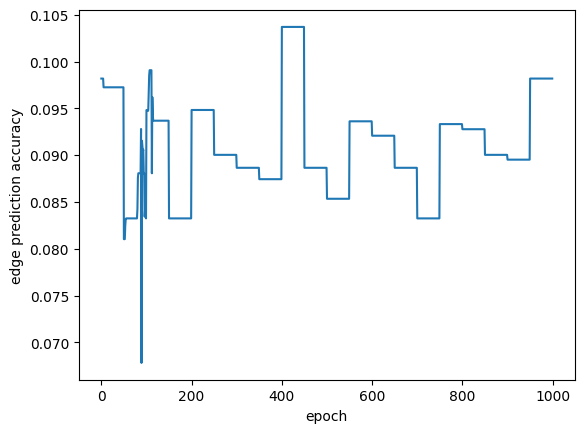

In [ ]:
import tqdm
from tqdm import tqdm_notebook
import torch
import networkx as nx
from torch_geometric.utils import from_networkx
from torch_sparse import SparseTensor
# model = GNNM(data.num_nodes, dataset.num_classes, 32, [64,64,64,64,64], eps=0.01).to(device)
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix






# test_dataset = dataset[:len(dataset) // 10]
# train_dataset = dataset[len(dataset) // 10:]
# test_loader = DataLoader(test_dataset)
# train_loader = DataLoader(train_dataset)

def train(dataset,data,true_edge):
    model.train()
    optimizer.zero_grad()
    # print(dataset.edge_index)
    out = model(dataset.features(),dataset.edge_index,None)
    # out = model(dataset)
    # print(out.shape)
    # loss_fn(out, data.y).backward()
    # breakpoint()
    # print(out)
    loss_fn(out,true_edge).backward()
    optimizer.step()


def test(true_y,epoch):
    model.eval()
    logits, accs = model(dataset.features(),dataset.edge_index,None), []
    # logits = model(dataset)
    # for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        # pred = logits[mask].max(1)[1]
    # print(logits[0])
    pred = logits  #logits[:].max(1)[1]
    # print(pred.shape)
    # print(pred,data.y)
    # print("pred is:",pred)
    thr=0.5
    pred = torch.where(pred > thr, torch.tensor(1), torch.tensor(0))
    # Convert tensors to numpy arrays
    true_y = true_y.numpy()
    pred = pred.numpy()

    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(true_y.flatten(), pred.flatten()).ravel()
    
    # Calculate precision and recall
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    # print(precision,recall)
    # Calculate F1 score
    f1_score = 2 * (precision * recall) / (precision + recall)
    print(f1_score)
    # print("true:",true_y)
    acc = f1_score
    # acc = pred.eq(true_y).sum().item()/(true_y.shape[0]*true_y.shape[1]) #/ mask.sum().item()
    # with torch.no_grad():
    #   # acc = loss_fn(pred, data.y)
    #   acc = loss_fn(pred, true_y)

    accs.append(acc)
    return accs

train_x=[]
# data = 0
# dataset = 0
g = random.choice(sample_train)
g_t = random.choice(sample_test)
data,dataset = make_data(g,g_t)

# model = GraphUNet(in_channels=dataset.num_node_features, hidden_channels=64, out_channels=dataset.num_node_features, depth=15)
model = edge_predict(dataset)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
# loss_fn = nn.MSELoss()#nn.CrossEntropyLoss()
# loss_fn = CustomMSELoss(weight_1=10.0, weight_0=2.0)
pos_weight = torch.tensor([220])

# Create the BCE loss function with weights
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# print(dataset)
for epoch in tqdm_notebook(range(0, 1000)):
    if(epoch%50==0):
        g = random.choice(sample_train)
        # x = from_networkx(g)
        # edge_index = x.edge_index.t()
        # get the adjacency matrix as a PyTorch tensor
        adj_matrix_g = torch.tensor(nx.adjacency_matrix(g).todense())
        adj_matrix_g = torch.nn.functional.pad(adj_matrix_g, (0, 0, 0, 30 - adj_matrix_g.shape[0]))
        adj_matrix_g= torch.nn.functional.pad(adj_matrix_g, (0, 30 - adj_matrix_g.shape[1]), mode='constant', value=0).float()
        if(epoch%10==0):
          g_t = random.choice(sample_test)
          # x = from_networkx(g_t)
          # edge_index = x.edge_index.t()
          adj_matrix_g_t = torch.tensor(nx.adjacency_matrix(g_t).todense())
          adj_matrix_g_t = torch.nn.functional.pad(adj_matrix_g_t, (0, 0, 0, 30 - adj_matrix_g_t.shape[0]))
          adj_matrix_g_t= torch.nn.functional.pad(adj_matrix_g_t, (0, 30 - adj_matrix_g_t.shape[1]), mode='constant', value=0).float()
        data,dataset = make_data(g,g_t)
    # print(dataset.features().shape)
    train(dataset,data,adj_matrix_g)
    accs = test(adj_matrix_g,epoch)
    train_acc = accs[0]
    train_x.append(train_acc)
    val_acc = 0#accs[1]
    test_acc = 0#accs[2]
    # print("epoch is {} loss is {}:".format(epoch,train_acc),)
    print("Val accuracy is {} loss is {}:".format(epoch,train_acc))
    # print('Epoch: {:03d}, Train Acc: {:.5f}, '
    #       'Val Acc: {:.5f}, Test Acc: {:.5f}'.format(epoch, train_acc, val_acc, test_acc))
plt.xlabel("epoch")
plt.ylabel("edge prediction accuracy")
plt.plot(np.arange(len(train_x)),train_x)

In [ ]:
(adj_matrix_g.sum()/(adj_matrix_g.shape[0]**2))**-1

tensor(21.9512)

In [ ]:
import torch

# Example tensor
x = torch.tensor([[0.2, 0.9, 0.4], [0.6, 0.1, 0.8]])

# Threshold value
thr = 0.5

# Convert elements to 1 if greater than thr, otherwise 0
y = torch.where(x > thr, torch.tensor(1), torch.tensor(0))

print(y)


tensor([[0, 1, 0],
        [1, 0, 1]])


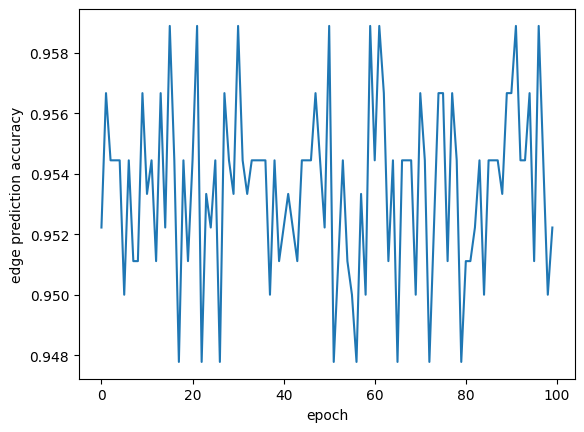

In [ ]:
val_epochs = 100
train_x = []
for i in range(val_epochs):
          g_t = random.choice(sample_test)
          # x = from_networkx(g_t)
          # edge_index = x.edge_index.t()
          adj_matrix_g_t = torch.tensor(nx.adjacency_matrix(g_t).todense())
          adj_matrix_g_t = torch.nn.functional.pad(adj_matrix_g_t, (0, 0, 0, 30 - adj_matrix_g_t.shape[0]))
          adj_matrix_g_t= torch.nn.functional.pad(adj_matrix_g_t, (0, 30 - adj_matrix_g_t.shape[1]), mode='constant', value=0).float()
          data,dataset = make_data(g,g_t)
          accs = test(adj_matrix_g_t)
          train_acc = accs[0]
          train_x.append(train_acc)
          
plt.xlabel("epoch")
plt.ylabel("edge prediction accuracy")
plt.plot(np.arange(len(train_x)),train_x)

In [ ]:
np.mean(train_x)

0.9535333333333333

In [ ]:
import torch

# Create a tensor matrix
tensor_matrix = torch.tensor([[1, 2], [3, 4]])

# Convert the tensor matrix datatype to float64
tensor_matrix = tensor_matrix.float().to(dtype=torch.float64)
tensor_matrix

tensor([[1., 2.],
        [3., 4.]], dtype=torch.float64)

In [ ]:
import torch
import networkx as nx
from torch_geometric.utils import from_networkx
from torch_sparse import SparseTensor

# create a directed graph using NetworkX
G = nx.DiGraph()
G.add_edge(0, 1)
G.add_edge(1, 2)
G.add_edge(2, 0)

# convert the graph to a PyTorch tensor
x = from_networkx(G)

# get the adjacency matrix as a PyTorch sparse tensor
edge_index = x.edge_index.t()
adj_matrix = SparseTensor(row=edge_index[:, 0], col=edge_index[:, 1], sparse_sizes=(x.num_nodes, x.num_nodes))

print(adj_matrix.to_dense())


tensor([[0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.]])


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

window_size = 1 # The size of the moving window
train_x_ma = pd.Series(train_x).rolling(window_size).mean()

# Plotting the moving average
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("GNN loss for network embedding (baking a cake)")
plt.plot(np.arange(len(train_x)), train_x_ma)
plt.show()


In [ ]:
E.keys()

dict_keys(['prepare-ingredients', 'pour-dough', 'get-ingredients', 'preheat', 'take-out-oven', 'put-cake-oven', 'add-ingredients', 'wait', 'decorate', 'get-utensils', 'cool-down', 'buy-ingredients', 'grease-cake-tin', 'set-time', 'choose-recipe', 'eat', 'check', 'turn-off-oven', 'take-out-cake-tin', 'other-make-cake', 'measure-ingredients', 'other-return-home', 'other-enter-kitchen', 'other-read-instructions', 'other-read-instrauctions', 'other-clean', 'other-return-oven', 'other-bake-extra-time', 'Victory'])

In [ ]:
dataset

MyDataset(768)

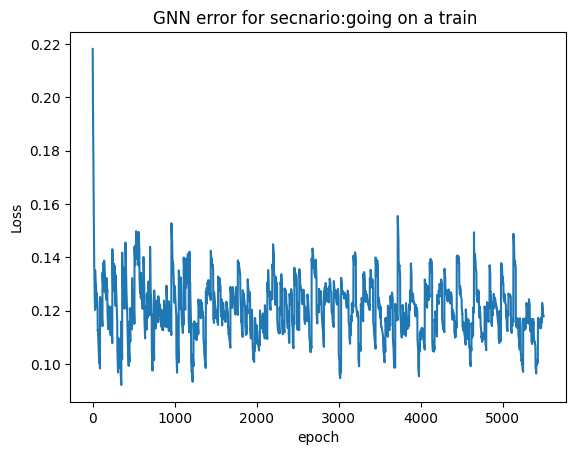

In [ ]:
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.title("GNN error for secnario:going on a train ")
plt.plot(np.arange(len(train_x)),train_x,)

In [ ]:
logits= model(dataset.features(),dataset.edge_index,None)
logits

tensor([[-0.3571,  0.7828,  0.0526,  ..., -0.3950,  0.1852,  0.4247],
        [ 0.1136,  0.2760, -0.2474,  ..., -0.1517, -0.0863,  0.3673],
        [ 0.0599,  0.1764, -0.2547,  ..., -0.1483, -0.0228,  0.3222],
        ...,
        [ 0.0953,  0.2504, -0.2508,  ..., -0.1502, -0.0658,  0.3572],
        [ 0.0527,  0.0359,  0.0039,  ..., -0.0153, -0.0252,  0.0222],
        [ 0.0527,  0.0359,  0.0039,  ..., -0.0153, -0.0252,  0.0222]],
       grad_fn=<AddBackward0>)

In [ ]:
data.edge_index


tensor([[ 2,  2,  2, 16, 17, 17, 17, 14,  8,  8,  9, 20, 20, 11, 11,  1,  1, 10,
         19, 22, 22, 27, 27, 27, 18,  3,  3,  3, 12, 25, 25, 25, 25,  6,  6,  7,
         15, 21, 21, 21, 23, 23, 23, 13, 26,  5,  5,  4, 24],
        [16, 17,  4, 17, 14,  8,  4,  8,  9, 15, 20, 11, 15,  1, 21, 10, 21, 19,
         22, 27, 23, 18,  3,  5,  3, 12, 26, 25, 25,  6,  7,  5, 24,  7,  0,  0,
         21, 22, 19, 10, 13, 27, 25, 27, 25,  6, 24,  8,  6]])

In [ ]:
len(G_main.nodes)==len(graph.nodes)

True

### Gated Graph Neural Network

In [ ]:
class GatedGraphConv(MessagePassing):
    
    def __init__(self, out_channels, num_layers, aggr = 'add',
                 bias = True, **kwargs):
        super(GatedGraphConv, self).__init__(aggr=aggr, **kwargs)

        self.out_channels = out_channels
        self.num_layers = num_layers

        self.weight = Param(Tensor(num_layers, out_channels, out_channels))
        self.rnn = torch.nn.GRUCell(out_channels, out_channels, bias=bias)

        self.reset_parameters()

    def reset_parameters(self):
        uniform(self.out_channels, self.weight)
        self.rnn.reset_parameters()

    def forward(self, data):
        """"""
        x = data.x
        edge_index = data.edge_index
        edge_weight = data.edge_attr
        if x.size(-1) > self.out_channels:
            raise ValueError('The number of input channels is not allowed to '
                             'be larger than the number of output channels')

        if x.size(-1) < self.out_channels:
            zero = x.new_zeros(x.size(0), self.out_channels - x.size(-1))
            x = torch.cat([x, zero], dim=1)

        for i in range(self.num_layers):
            m = torch.matmul(x, self.weight[i])
            m = self.propagate(edge_index, x=m, edge_weight=edge_weight,
                               size=None)
            x = self.rnn(m, x)

        return x

    def message(self, x_j, edge_weight):
        return x_j if edge_weight is None else edge_weight.view(-1, 1) * x_j

    def message_and_aggregate(self, adj_t, x):
        return matmul(adj_t, x, reduce=self.aggr)

    def __repr__(self):
        return '{}({}, num_layers={})'.format(self.__class__.__name__,
                                              self.out_channels,
                                              self.num_layers)

class GGNN(torch.nn.Module):
    def __init__(self):
        super(GGNN, self).__init__()
        
        self.conv = GatedGraphConv(1433, 3)
        self.mlp = MLP(1433, [32,32,32], dataset.num_classes)
        
    def forward(self):
        x = self.conv(data)
        x = self.mlp(x)
        return F.log_softmax(x, dim=-1)


In [ ]:
# //model = GGNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()


test_dataset = dataset[:len(dataset) // 10]
train_dataset = dataset[len(dataset) // 10:]
test_loader = DataLoader(test_dataset)
train_loader = DataLoader(train_dataset)

def train():
    model.train()
    optimizer.zero_grad()
    loss_fn(model()[data.train_mask], data.y[data.train_mask]).backward()
    optimizer.step()


def test():
    model.eval()
    logits, accs = model(), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs


for epoch in range(1, 51):
    train()
    accs = test()
    train_acc = accs[0]
    val_acc = accs[1]
    test_acc = accs[2]
    print('Epoch: {:03d}, Train Acc: {:.5f}, '
          'Val Acc: {:.5f}, Test Acc: {:.5f}'.format(epoch, train_acc,
                                                       val_acc, test_acc))

AttributeError: ignored

In [ ]:
data

In [ ]:
data.edge_index